In [223]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
import pickle

import matplotlib
matplotlib.rcParams.update({"text.usetex": True, "font.family": "Times"})

In [224]:
# Read in the model parameters from the top of the data file
with open("../data/data.csv", "r") as f:
    params = dict([(param, float(val)) for (param, val) in [pair.split('=') for pair in f.readline().split(',')]])

In [225]:
# Read in the dataset from the CSV file
df = pd.read_csv("../data/data.csv", skiprows=1)

In [226]:
# Separate the dataset into the group, features, and target variable
grp = df["group"]
X = df.drop(columns=["group", "u"])
y = df["u"]

In [276]:
models = [
    {"model": Pipeline([("pf", PolynomialFeatures()), ("ss", StandardScaler()), ("ridge", Ridge(random_state=0))]),
     "search_space": {"pf__degree": Integer(1, 6), "ridge__alpha": Real(1e-5, 1e5, prior="log-uniform")},
     "name": "Polynomial Ridge"},
    {"model": DecisionTreeRegressor(random_state=0),
     "search_space": {"max_depth": Integer(1, 40)},
     "name": "Decision Tree"},
    {"model": RandomForestRegressor(n_estimators=10, random_state=0),
     "search_space": {"max_depth": Integer(1, 40), "max_samples": Real(0.01, 0.99, "uniform")},
     "name": "Random Forest"},
    {"model": XGBRegressor(n_estimators=10, random_state=0),
     "search_space": {"max_depth": Integer(1, 40), "reg_alpha": Real(1e-6, 1e6, "log-uniform"), "reg_lambda": Real(1e-6, 1e6, "log-uniform")},
     "name": "XGBoost"}
]

In [277]:
for model in models:
    print("tuning hyperparameters for {}...".format(model["name"]))
    bs = BayesSearchCV(model["model"], model["search_space"], n_iter=50, cv=GroupKFold(n_splits=5), return_train_score=True, random_state=0)
    bs.fit(X, y, grp)
    model["train_scores"] = (bs.cv_results_["mean_train_score"], bs.cv_results_["std_train_score"])
    model["valid_scores"] = (bs.cv_results_["mean_test_score"], bs.cv_results_["std_test_score"])
    model["best_params"] = bs.best_params_
    model["model"] = bs.best_estimator_
    print("best params: ", bs.best_params_)
    print("estimating accuracy...")
    model["test_scores"] = []
    for train_idx, test_idx in GroupKFold(n_splits=10).split(X, y, grp):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        model["model"].fit(X_train, y_train)
        model["test_scores"].append(model["model"].score(X_test, y_test))

tuning hyperparameters for Polynomial Ridge...
best params:  OrderedDict([('pf__degree', 6), ('ridge__alpha', 5.7390129756747676e-05)])
estimating accuracy...
tuning hyperparameters for Decision Tree...


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

best params:  OrderedDict([('max_depth', 26)])
estimating accuracy...
tuning hyperparameters for Random Forest...
best params:  OrderedDict([('max_depth', 24), ('max_samples', 0.99)])
estimating accuracy...
tuning hyperparameters for XGBoost...
best params:  OrderedDict([('max_depth', 20), ('reg_alpha', 3.480761065075856e-05), ('reg_lambda', 0.7701675437205197)])
estimating accuracy...


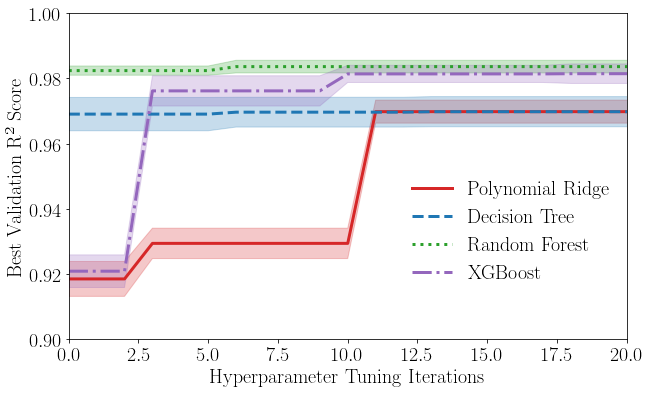

In [292]:
def argmax_accum(arr):
    idx = []
    for i, a in enumerate(arr):
        idx.append(i if not idx or a > arr[idx[-1]] else idx[-1])
    return idx

plt.figure(figsize=(10,6))
for model, color, ls in zip(models, ["tab:red", "tab:blue", "tab:green", "tab:purple"], ["-", "--", ":", "-."]):
    m = np.array(model["valid_scores"][0])
    s = np.array(model["valid_scores"][1])
    m = np.hstack((m[0], m))
    s = np.hstack((s[0], s))
    idx = argmax_accum(m)
    plt.fill_between(np.arange(len(m)), m[idx] - s[idx], m[idx] + s[idx], alpha=0.25, color=color)
    plt.plot(np.arange(len(m)), m[idx], label=model["name"], color=color, ls=ls, lw=3)

font = font_manager.FontProperties(size=20)
plt.legend(frameon=False, prop=font, loc=[0.6, 0.15], ncol=1)
plt.xlim(0, 20)
plt.ylim(0.9, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Hyperparameter Tuning Iterations", fontsize=20)
plt.ylabel(u"Best Validation R\u00b2 Score", fontsize=20)
plt.savefig("../figures/model/train-convergence.svg")

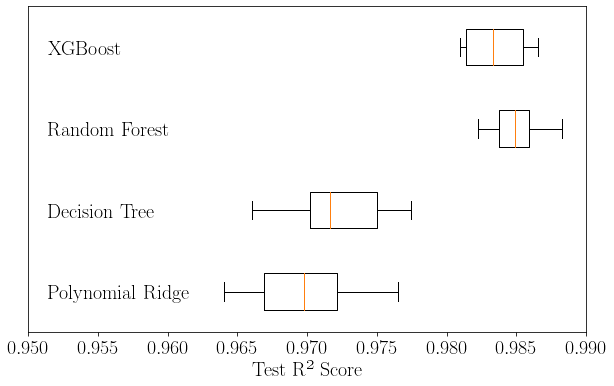

In [297]:
plt.figure(figsize=(10,6))
plt.boxplot([model["test_scores"] for model in models], vert=False, labels=[model["name"] for model in models])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, ha="left")
plt.tick_params(axis="y", pad=-20, length=0)
plt.xlabel(u"Test R\u00b2 Score", fontsize=20)
plt.xlim(0.95, 0.99)
plt.savefig("../figures/model/test-scores.svg")

In [338]:
for model in models:
    model["model"].fit(X, y)
    
pickle.dump(models, open("trained-model.pkl", "wb"))

In [339]:
model = models[3]["model"]

booster = model.get_booster() 
model_bytearray = booster.save_raw()[4:]
booster.save_raw = lambda : model_bytearray

explainer = shap.TreeExplainer(booster)

np.random.seed(0)
X_shap = X.iloc[np.random.choice(len(X), 5000, replace=False)]
shap_values = explainer.shap_values(X_shap)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


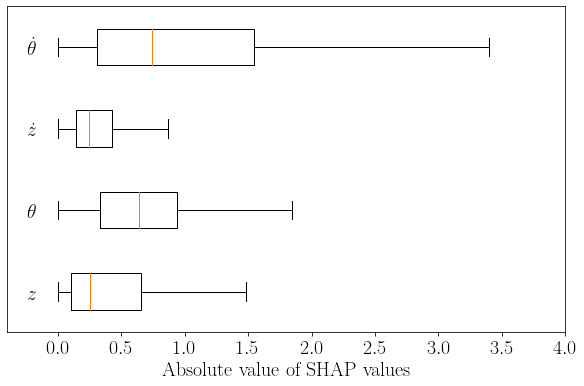

In [340]:
labels = {"z": r"$z$", "theta": r"$\theta$", "z_dot": r"$\dot{z}$", "theta_dot": r"$\dot{\theta}$"}

plt.figure(figsize=(10, 6))
plt.boxplot(np.abs(shap_values), vert=False, labels=[labels[col] for col in X_shap.columns], showfliers=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, ha="left")
plt.tick_params(axis="y", pad=-20, length=0)
plt.xlim(-0.4, 4)
plt.xlabel("Absolute value of SHAP values", fontsize=20)
plt.savefig("../figures/model/shap-values.svg")